<a href="https://colab.research.google.com/github/tahira4/Predicting-Movie-Success-Based-on-Sentiment-Analysis-/blob/main/CMPSC446_MoviePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries (if not already installed)
!pip install scikit-learn wordcloud tensorflow nltk

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
from google.colab import files

# Prompt the user to upload the file
uploaded = files.upload()  # This will open a file picker in the browser

# Retrieve the uploaded file name
file_name = list(uploaded.keys())[0]
print(f"Uploaded file: {file_name}")

# Extract the file if it's a ZIP archive
import zipfile

if file_name.endswith('.zip'):
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(".")
        print("Extracted files:", zip_ref.namelist())


Saving IMDB Dataset.csv.zip to IMDB Dataset.csv (1).zip
Uploaded file: IMDB Dataset.csv (1).zip
Extracted files: ['IMDB Dataset.csv']


In [ ]:
# Load dataset into a pandas DataFrame
file_name = list(uploaded.keys())[0]  # Get uploaded file name
data = pd.read_csv(file_name)

In [ ]:
# Inspect the dataset
print("Dataset Shape:", data.shape)
print("Sample Data:", data.head())

Dataset Shape: (50000, 2)
Sample Data:                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Step 1: Text Cleaning
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply cleaning to the reviews
data['cleaned_review'] = data['review'].apply(clean_text)

In [ ]:
# Encode Sentiments (positive -> 1, negative -> 0)
data['sentiment_encoded'] = data['sentiment'].map({'positive': 1, 'negative': 0})

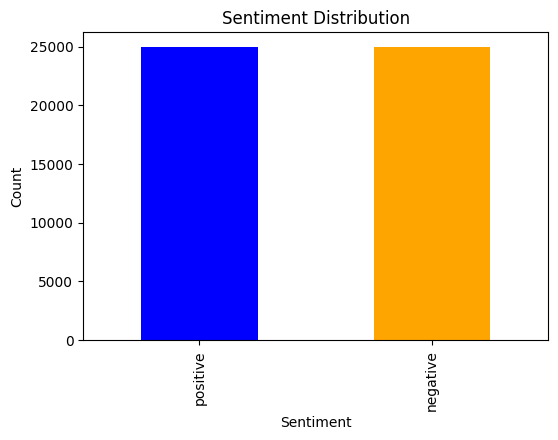

In [ ]:
# Plot sentiment distribution
plt.figure(figsize=(6, 4))
data['sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
# Generate word clouds
positive_reviews = " ".join(data[data['sentiment'] == "positive"]['cleaned_review'])
negative_reviews = " ".join(data[data['sentiment'] == "negative"]['cleaned_review'])

positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wc = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)


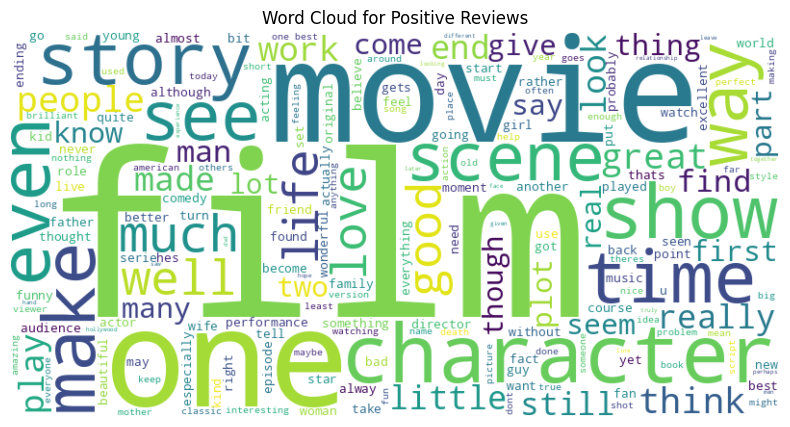

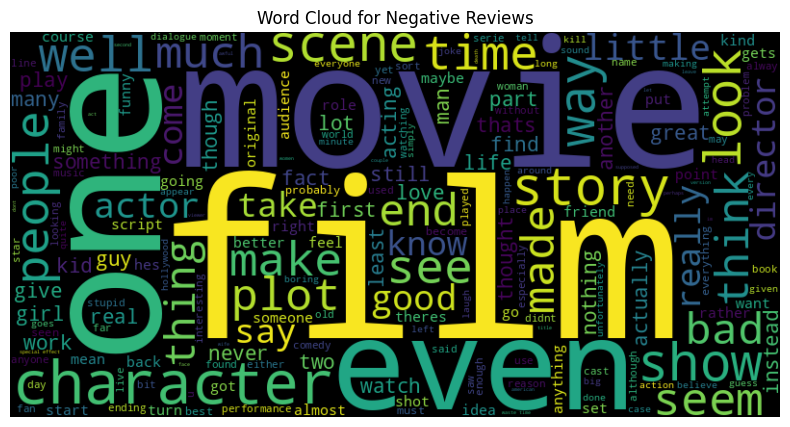

In [ ]:
# Display word clouds
plt.figure(figsize=(10, 5))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [ ]:
# Step 2: Tokenization and Padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_review'])

X = tokenizer.texts_to_sequences(data['cleaned_review'])
X = pad_sequences(X, maxlen=max_len)
y = np.array(data['sentiment_encoded'])

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 3: Building a Deep Learning Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),  # Removed `input_length`
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Explicitly build the model to avoid uninitialized errors
model.build(input_shape=(None, max_len))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the summary
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 825,217 (3.15 MB)

 Trainable params: 825,217 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Step 4: Training the Model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 236s 462ms/step - accuracy: 0.7564 - loss: 0.4679 - val_accuracy: 0.8700 - val_loss: 0.3039
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 453ms/step - accuracy: 0.8982 - loss: 0.2629 - val_accuracy: 0.8781 - val_loss: 0.2919
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 226s 452ms/step - accuracy: 0.9166 - loss: 0.2182 - val_accuracy: 0.8726 - val_loss: 0.3161
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 260s 449ms/step - accuracy: 0.9342 - loss: 0.1753 - val_accuracy: 0.8726 - val_loss: 0.3428
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 263s 452ms/step - accuracy: 0.9513 - loss: 0.1368 - val_accuracy: 0.8691 - val_loss: 0.3923


In [ ]:
# Step 5: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - accuracy: 0.8652 - loss: 0.3937
Test Accuracy: 86.53%


In [ ]:
# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      4961
           1       0.85      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



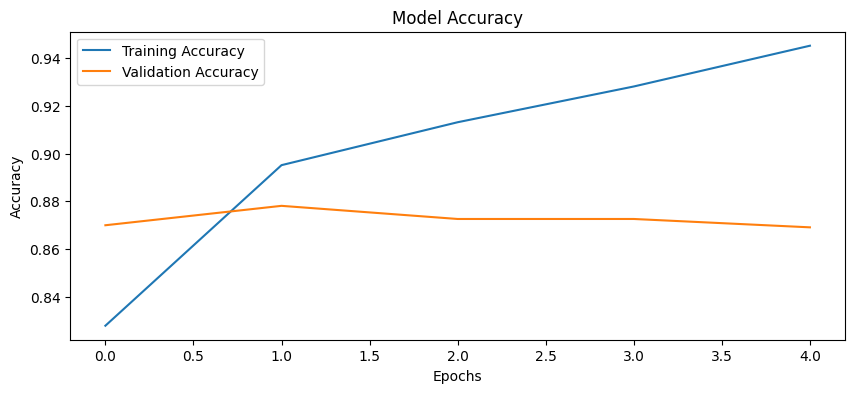

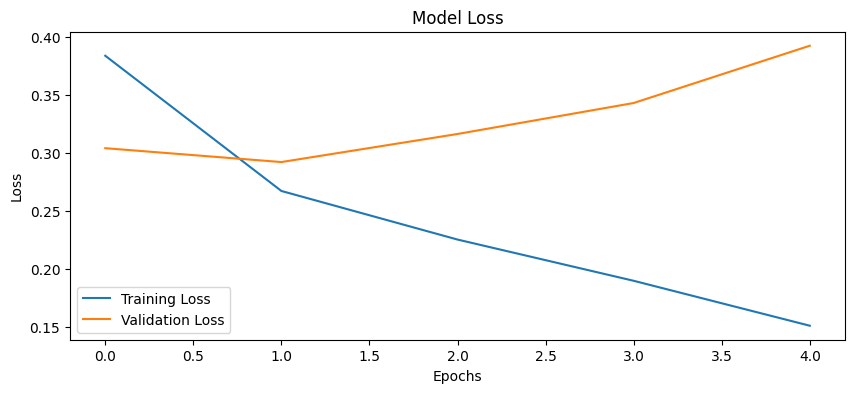

In [ ]:
# Step 6: Plot Training Performance
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()